##      **Rick and Morty Character Image Detection**

# Downloading the Dataset
First, we need to install the Kaggle API and authenticate it to download the "Rick and Morty" dataset.

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()  # Upload your Kaggle API key (kaggle.json) downloaded from your Kaggle account settings
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d mriffaud/rick-and-morty
!unzip rick-and-morty.zip -d rick_and_morty_dataset

Streaming output truncated to the last 5000 lines.
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_173632.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_173840.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_174049.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_174257.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_174466.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_174675.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_174883.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_175092.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_175300.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_175509.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_208041.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_208250.jpg  
  inflating: rick_and_morty_dataset/rick_and_mort

# Moving the folders to train directory

This code organizes training datasets by moving each folder containing training data to a new directory named 'train'.

In [3]:
import os

# Define paths
base_dir = '/content/rick_and_morty_dataset/rick_and_morty'
train_dir = os.path.join(base_dir, 'train')

# Create the 'train' folder if it doesn't exist
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

# Move folders to the 'train' folder
folders_to_move = ['Beth', 'Jerry', 'Morty', 'Rick', 'Summer']
for folder in folders_to_move:
    src = os.path.join(base_dir, folder)
    dst = os.path.join(train_dir, folder)
    os.rename(src, dst)

# Creating CSV files for train and test dataset :-

we are pre-processing the data and creating train_data.csv and test_data.csv file with columns image_path and label for further processing:-


In [4]:
import os
import pandas as pd

# Path to your dataset directory
train_dir = '/content/rick_and_morty_dataset/rick_and_morty/train'  # Update this path accordingly

# Initialize lists to store image paths and labels
image_paths = []
labels = []

# Traverse through sub-folders in the train directory
for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    if os.path.isdir(label_dir):
        for image_name in os.listdir(label_dir):
            if image_name.endswith('.jpg') or image_name.endswith('.png'):  # Adjust as per your image format
                image_path = os.path.join(label_dir, image_name)
                image_paths.append(image_path)
                labels.append(label)

# Create a DataFrame to store the image paths and labels
data = {'Image_Path': image_paths, 'Label': labels}
df = pd.DataFrame(data)

# Save DataFrame to a CSV file
csv_file_path = '/content/rick_and_morty_dataset/rick_and_morty/train_data.csv'  # Specify the desired CSV file path
df.to_csv(csv_file_path, index=False)

print("CSV train file saved successfully!")

CSV train file saved successfully!


In [5]:
import os
import pandas as pd

# Define the path to the test folder containing images
test_folder = '/content/rick_and_morty_dataset/rick_and_morty/test'

# Initialize lists to store image paths and labels
image_paths = []
labels = []

# Iterate through each image file in the test folder
for image_name in os.listdir(test_folder):
    if image_name.endswith('.jpg') or image_name.endswith('.png'):
        image_path = os.path.join(test_folder, image_name)
        image_paths.append(image_path)
        # Since there are no subfolders, we can assign a default label
        labels.append('Unknown')

# Create a DataFrame with image paths and labels
df = pd.DataFrame({'Image_Path': image_paths, 'Label': labels})

# Save DataFrame to CSV file named test.csv
csv_file_path = '/content/rick_and_morty_dataset/rick_and_morty/test_data.csv'
df.to_csv(csv_file_path, index=False)

print("CSV test file saved successfully!")

CSV test file saved successfully!


# Importing Libraries :-

we need to import machine learning related API's for image processing , manipulating layers and model vgg16 with pre-trained weights , pandas for reading csv files into dataframes and Matplotlib for creating visualizations, such as line plots, bar charts :-

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras import layers, models, optimizers


# Creating Data Generators for Image Classification
This code snippet summarizes the process of creating data generators for training and validation sets . It includes setting up image data augmentation for the training set (train_datagen) and scaling for the testing set (test_datagen), defining the batch size and target image size, and loading the dataset using the flow_from_directory method with categorical class mode for image classification tasks.

In [7]:
from sklearn.model_selection import train_test_split
# Load train and test CSV files
df = pd.read_csv('/content/rick_and_morty_dataset/rick_and_morty/train_data.csv')

# Select a subset of 1000 samples for training and 50 samples for testing
train_df, val_df = train_test_split(df, train_size=0.8, test_size=0.2, random_state=42)

In [8]:
# Define data generators for train and validation sets
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

# Set batch size and target image size
batch_size = 32
target_size = (224, 224)

In [9]:
# Create train and validation generators using flow_from_dataframe for categorical classification
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col='Image_Path',  # Assuming 'Image_Path' column contains image paths
                                                    y_col='Label',  # Assuming 'Label' column contains image labels (categories)
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')  # Specify class_mode as 'categorical'

validation_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                        x_col='Image_Path',
                                                        y_col='Label',
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 7530 validated image filenames belonging to 5 classes.
Found 1883 validated image filenames belonging to 5 classes.


# Loading the Base-Model
This code snippet defines a InceptionV3 base model in Keras. The model is configured with an input shape of (224, 224, 3) to match the size and channels of the images in your dataset. It includes all layers of the InceptionV3 model up to the final fully connected layers but excludes the last fully connected layer, which is often customized for specific tasks.

In [10]:
img_shape = (224, 224, 3)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

87910968/87910968 [==============================] - 1s 0us/step


# Customizing it according to our usecase
This code snippet summarizes the process of creating a custom InceptionV3-based categorical classification model in Keras. It involves loading the pre-trained InceptionV3 model, freezing its layers, adding custom layers for classification, compiling the model, shuffling the training data, and training the model. Finally, the trained model is saved as an HDF5 file (inceptionV3_model_categorical.h5).

In [11]:
from keras import Sequential
from keras.layers import Dense
from keras import optimizers

# Freeze the base model layers
base_model.trainable = False

# Create a new model by adding custom layers on top of the base model
model = Sequential([
    base_model,
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')  # Adjust the number of units for your classification task
])

# Compile the model
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 22984485 (87.68 MB)
Trainable params: 1181701 (4.51 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [14]:
# Train the model
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10)

# Optionally, you can save the trained model
model.save('inceptionv3_model_categorical.h5')

Epoch 1/10
236/236 [==============================] - 1343s 6s/step - loss: 0.7447 - accuracy: 0.7268 - val_loss: 0.3836 - val_accuracy: 0.8630
Epoch 2/10
236/236 [==============================] - 1351s 6s/step - loss: 0.3626 - accuracy: 0.8701 - val_loss: 0.3921 - val_accuracy: 0.8555
Epoch 3/10
236/236 [==============================] - 1344s 6s/step - loss: 0.2724 - accuracy: 0.9021 - val_loss: 0.1972 - val_accuracy: 0.9304
Epoch 4/10
236/236 [==============================] - 1337s 6s/step - loss: 0.2484 - accuracy: 0.9122 - val_loss: 0.1529 - val_accuracy: 0.9506
Epoch 5/10
236/236 [==============================] - 1339s 6s/step - loss: 0.1988 - accuracy: 0.9264 - val_loss: 0.2209 - val_accuracy: 0.9102
Epoch 6/10
236/236 [==============================] - 1355s 6s/step - loss: 0.2018 - accuracy: 0.9283 - val_loss: 0.1786 - val_accuracy: 0.9352
Epoch 7/10
236/236 [==============================] - 1346s 6s/step - loss: 0.1695 - accuracy: 0.9400 - val_loss: 0.1785 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Plotting the graph:-
This code plots the training and validation loss and accuracy over the epochs. The loss and accuracy values from the history object are used to create line plots. The x-axis represents the epoch number, while the y-axis represents the loss or accuracy. Separate plots are created for training and validation data, and legends are added to differentiate them.

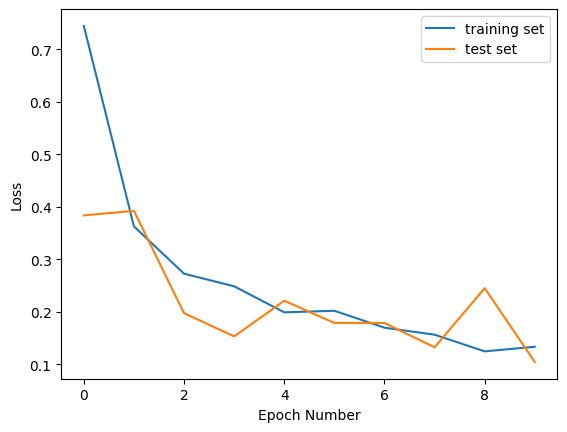

In [15]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

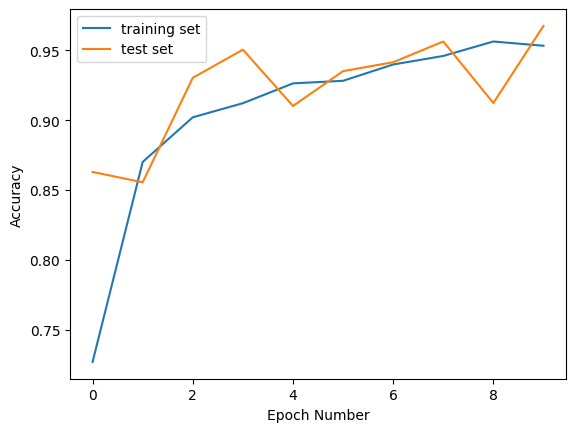

In [16]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

# Testing and labeling unseen data

In [17]:
from tqdm import tqdm
import numpy as np
from keras.utils import load_img , img_to_array


test = pd.read_csv('/content/rick_and_morty_dataset/rick_and_morty/test_data.csv')
test_df = test

test_image = []

for i in tqdm(range(test.shape[0])):
    img = load_img(test['Image_Path'][i], target_size=(224,224,3), grayscale=False)
    img = img_to_array(img)
    img = img/255
    test_image.append(img)

test = np.array(test_image)

prediction_probs = model.predict(test)
prediction = np.argmax(prediction_probs, axis=1)

print(test_df)

100%|██████████| 375/375 [00:09<00:00, 38.34it/s]


12/12 [==============================] - 54s 4s/step
                                            Image_Path    Label
0    /content/rick_and_morty_dataset/rick_and_morty...  Unknown
1    /content/rick_and_morty_dataset/rick_and_morty...  Unknown
2    /content/rick_and_morty_dataset/rick_and_morty...  Unknown
3    /content/rick_and_morty_dataset/rick_and_morty...  Unknown
4    /content/rick_and_morty_dataset/rick_and_morty...  Unknown
..                                                 ...      ...
370  /content/rick_and_morty_dataset/rick_and_morty...  Unknown
371  /content/rick_and_morty_dataset/rick_and_morty...  Unknown
372  /content/rick_and_morty_dataset/rick_and_morty...  Unknown
373  /content/rick_and_morty_dataset/rick_and_morty...  Unknown
374  /content/rick_and_morty_dataset/rick_and_morty...  Unknown

[375 rows x 2 columns]


In [18]:
from sklearn.preprocessing import LabelEncoder
class_indices_inverse = {v: k for k, v in train_generator.class_indices.items()}

# Perform inverse label encoding on predictions
prediction = [class_indices_inverse[label] for label in prediction]

predicted_df = pd.DataFrame({
    'Image_Path': test_df['Image_Path'],  # Use 'Image_Path' from your 'test' DataFrame
    'Label': prediction,  # Use your predicted labels
})

# Specify the path where you want to save the CSV file
csv_path = '/content/rick_and_morty_dataset/rick_and_morty/predicted.csv'

# Write the DataFrame to a CSV file
predicted_df.to_csv(csv_path, header=True, index=False)

# image label and prediction and visualization

1/1 [==============================] - 0s 322ms/step


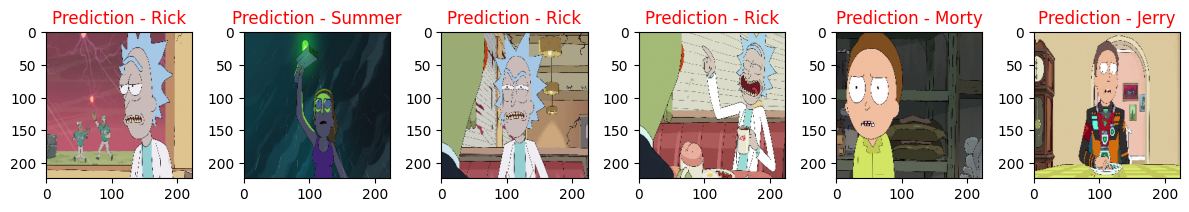

In [26]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_image(filenames, model):
    classes = ["Beth", "Jerry", "Morty", "Rick" , "Summer"]  # Define your class names
    num_images = len(filenames)

    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

    for i, filename in enumerate(filenames):
        img_ = image.load_img(filename, target_size=(224, 224))  # Adjust target_size as needed
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0)
        img_processed /= 255.

        prediction = model.predict(img_processed)
        index = np.argmax(prediction)

        ax = axes[i] if num_images > 1 else axes
        ax.imshow(img_array)
        ax.set_title("Prediction - {}".format(str(classes[index]).title()), size=12, color='red')

    plt.tight_layout()
    plt.show()

# Example usage
filenames = [
    '/content/rick_and_morty_dataset/rick_and_morty/test/3_E1_237237.jpg',
   '/content/rick_and_morty_dataset/rick_and_morty/test/3_E1_391349.jpg',
    '/content/rick_and_morty_dataset/rick_and_morty/test/3_E1_216800.jpg',
    '/content/rick_and_morty_dataset/rick_and_morty/test/3_E1_68527.jpg',
    '/content/rick_and_morty_dataset/rick_and_morty/test/3_E1_263513.jpg',
   '/content/rick_and_morty_dataset/rick_and_morty/test/3_E1_159242.jpg'

]

predict_image(filenames, model)

# importing libraries for classification report , accuracy score and confusion matrix:-

In [28]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved model
model = models.load_model('inceptionv3_model_categorical.h5')

# Evaluate the model on the original validation data
val_images, val_labels = next(iter(validation_generator))
val_predictions = model.predict(val_images)
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = np.argmax(val_labels, axis=1)


1/1 [==============================] - 6s 6s/step


# f1 score

In [29]:
 # Classification Report
print('Classification Report:')
print(classification_report(val_true_labels, val_pred_labels, zero_division=1))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



# accuracy score

In [32]:
# Accuracy Score
accuracy = accuracy_score(val_true_labels, val_pred_labels)
print('Accuracy Score:', accuracy)

Accuracy Score: 1.0


# confusion matrix

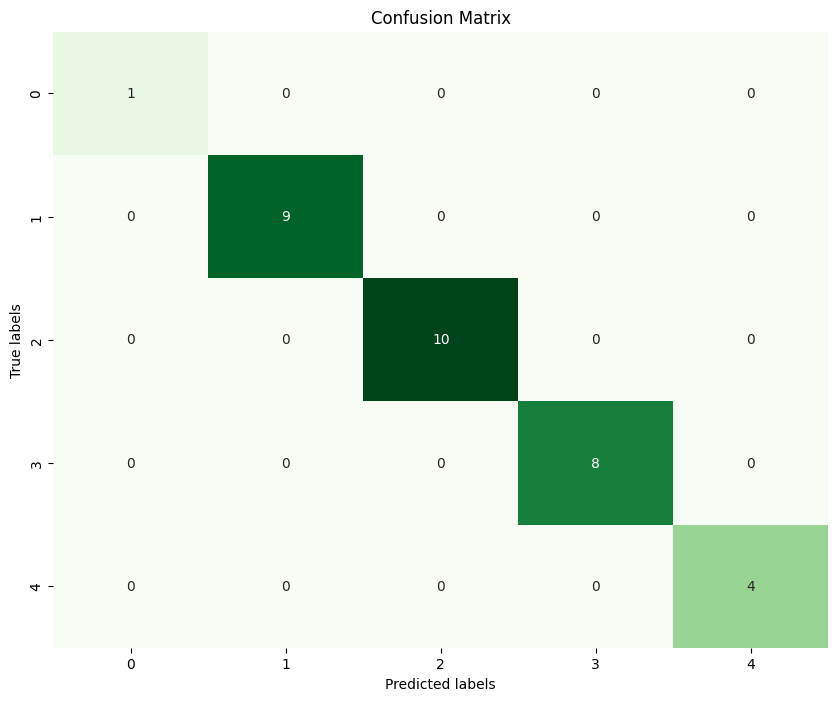

In [31]:
# Confusion Matrix
cm = confusion_matrix(val_true_labels, val_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()